# The Netflix Recommendation Problem - Dimension Reduction Techniques

- Authors: Ba Khuong DANG, Kartik VISWANATHAN

- MSD 2024-25

## Read the dataset

In [1]:
!wget -O ml-latest-small.zip -N https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip -o ml-latest-small.zip

for details.

--2025-02-18 12:11:33--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955,28K   372KB/s    in 2,6s    

2025-02-18 12:11:41 (372 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [3]:
# Load ther ratings.csv file into a pandas dataframe
import pandas as pd
ratings = pd.read_csv('ml-latest-small/ratings.csv')

print(ratings.shape)
ratings.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Sparse Representation
* Since the data is sparse (most users have not rated most movies), we should represent the data in a sparse format to save memory and improve computational efficiency.
* The sparse format typically represents the data as a user-item matrix, where rows correspond to users, columns correspond to movies, and the values are the ratings.

### Features
* UserID and MovieID are categorical features and should be encoded using one-hot encoding or LabelEncoding
* Rating is the target variable (output) we want to predict
* Timestamp can be dropped as it won't contain any information regarding the ratings

In [4]:
# Label encode the user and movie ids
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders
user_enc = LabelEncoder()
movie_enc = LabelEncoder()

# Fit and transform the training data
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
ratings['movie'] = movie_enc.fit_transform(ratings['movieId'].values)

# Display the first few rows of the test data
print("\nRatings data:")
print(ratings.head())


Ratings data:
   userId  movieId  rating  timestamp  user  movie
0       1        1     4.0  964982703     0      0
1       1        3     4.0  964981247     0      2
2       1        6     4.0  964982224     0      5
3       1       47     5.0  964983815     0     43
4       1       50     5.0  964982931     0     46


In [5]:
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

#create a sparse matrix of train data
n_users = ratings['user'].max() + 1
n_movies = ratings['movie'].max() + 1
print(f"Number of user: {n_users}")
print(f"Number of movie: {n_movies}")

sparse_matrix_train = csr_matrix((ratings['rating'], (ratings['user'], ratings['movie'])), shape=(n_users, n_movies))
nb_nonzero = sparse_matrix_train.count_nonzero()
sparsity = 1 - (nb_nonzero / (sparse_matrix_train.shape[0] * sparse_matrix_train.shape[1]))

print(sparse_matrix_train.shape)
print(f"Number of nonzero elements: {nb_nonzero}")
print(f"Sparsity level: {sparsity * 100:.2f}%")
print(sparse_matrix_train)


# Create the mask for observed data
mask = sparse_matrix_train.copy()
mask.data[:] = 1

Number of user: 610
Number of movie: 9724
(610, 9724)
Number of nonzero elements: 100836
Sparsity level: 98.30%
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 100836 stored elements and shape (610, 9724)>
  Coords	Values
  (0, 0)	4.0
  (0, 2)	4.0
  (0, 5)	4.0
  (0, 43)	5.0
  (0, 46)	5.0
  (0, 62)	3.0
  (0, 89)	5.0
  (0, 97)	4.0
  (0, 124)	5.0
  (0, 130)	5.0
  (0, 136)	5.0
  (0, 184)	5.0
  (0, 190)	3.0
  (0, 197)	5.0
  (0, 201)	4.0
  (0, 224)	5.0
  (0, 257)	3.0
  (0, 275)	3.0
  (0, 291)	5.0
  (0, 307)	4.0
  (0, 314)	4.0
  (0, 320)	5.0
  (0, 325)	4.0
  (0, 367)	3.0
  (0, 384)	4.0
  :	:
  (609, 9238)	5.0
  (609, 9246)	4.5
  (609, 9256)	4.0
  (609, 9268)	5.0
  (609, 9274)	3.5
  (609, 9279)	3.5
  (609, 9282)	3.0
  (609, 9288)	3.0
  (609, 9304)	3.0
  (609, 9307)	2.5
  (609, 9312)	4.5
  (609, 9317)	3.0
  (609, 9324)	3.0
  (609, 9339)	4.0
  (609, 9341)	4.0
  (609, 9348)	3.5
  (609, 9371)	3.5
  (609, 9372)	3.5
  (609, 9374)	5.0
  (609, 9415)	4.0
  (609, 9416)	4.0
  (609, 9443)	5.

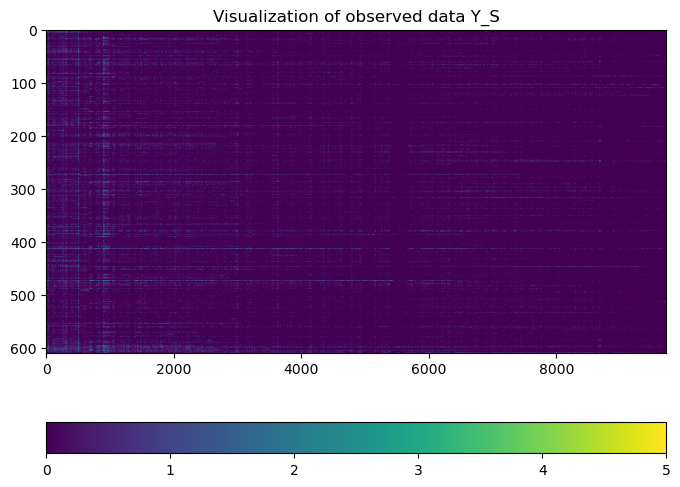

In [6]:
import matplotlib.pyplot as plt

# Plot the sparse matrix
plt.figure(figsize=(8, 6))  
im = plt.imshow(sparse_matrix_train.toarray(), aspect='auto', cmap='viridis') 
plt.colorbar(im, orientation='horizontal')  
plt.title("Visualization of observed data Y_S")
plt.show()

## Rank estimation for matrix completion

The rank is calculated based on $\epsilon$ which is a fixed parameter that determines the level at which singular values are "shrunk" towards zero

In [7]:
import numpy as np
from scipy.sparse.linalg import svds


def rank_calculator(sparse_matrix_train, epsilon):

    # Convert to array
    train_data_matrix = sparse_matrix_train.toarray()

    # Perform SVD
    u, s, vt = svds(train_data_matrix, k=min(train_data_matrix.shape) - 1)

    # Sort the s values in descending order
    s = np.sort(s)[::-1]

    # find the 1st difference
    diff0 = s[0] - s[1]

    for i in range(1, len(s) - 1):
        if s[i] - s[i + 1] < (diff0 * epsilon):
            tau = s[i]
            rank = i + 1
            break

    total_energy = np.sum(s**2)  # Calculate total energy
    current_energy = np.sum(s[:rank] ** 2)  # Calculate energy based on the correct rank
    energy = (
        current_energy / total_energy
    )  # Calculate the energy based on the correct rank

    return rank, energy, tau

### Create the error calculation function

In [8]:
from scipy.sparse import issparse

# error calculation function for sparse matrix

def error_calc(X_S, Y_S):

    # Convert sparse matrices to dense arrays if necessary
    if issparse(X_S):
        X_S = X_S.toarray()
    if issparse(Y_S):
        Y_S = Y_S.toarray()
    
    #Norm calculation X_S - Y_S
    normXminusY = np.linalg.norm(X_S - Y_S, ord=2)

    #Norm of Y_S
    norm_Y = np.linalg.norm(Y_S, ord=2)

    if norm_Y == 0:
        raise ValueError("Norm of Y is 0")

    #Calculate the error
    error = normXminusY/norm_Y
  
    return error

## Singular Value Projection Algorithm

SVP aims to find a low-rank matrix $X$ that approximates an observed matrix $Y$ by solving:
$$
\min_{X} \|X - Y\|_F^2 \quad \text{subject to} \quad \text{rank}(X) \leq r
$$

where the rank $r$ is a fixed desired rank.

In [9]:
# Get the rank for 90% energy
rank, energy, tau = rank_calculator(sparse_matrix_train, 0.002)
print(f"rank = {rank} | energy = {energy:2f} | tau = {tau:3f}")

rank = 15 | energy = 0.420919 | tau = 99.873236


In [49]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.linalg import svds, norm
from sklearn.base import BaseEstimator
import time
from scipy.sparse import issparse
import matplotlib.pyplot as plt

In [63]:
# Base MatrixCompletion class to use for all 3 algorithms
class MatrixComletion(BaseEstimator):
    def __init__(self, rank=10, max_iter=100, tol=1e-3, learning_rate=1):
        self.rank = rank
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.X = None
        self.fit_time = None
        self.error = [1., ]  # The 1st relative error will always be 1 (100% incorrect)
        self.fit_time = []
        self.iter = None
        

    def stop_condition(self):
        '''
        Check stopping criteria:
        - err(Xt , Y ) < tol for some tol > 0, or
        - err(Xt+1 , Y ) < err(Xt , Y ), i.e. the algorithm performance stops improving, or
        - iteration > max number of iteration
        Return: 
            - True if any of these 3 conditions is met. 
        '''
        cri1 = self.error[-1] < self.tol
        cri2 = self.iter > self.max_iter
        cri3 = self.error[-2] < self.error[-1]
        return (cri1 or cri2 or cri3)


    def fit(self, Y, mask):
        return NotImplementedError
    

    def score(self, Y, y=None):
        # Extract observed entries in the validation fold
        val_indices = list(zip(Y.nonzero()[0], Y.nonzero()[1]))
        val_values = Y.data

        # Compute the error only on the observed entries in the validation fold
        error = self._error_calc_validation(self.X, val_indices, val_values)
        return -error  # For scikit-learn, higher score is better


    def _error_calc(self, X_S, Y_S):

        # # Convert sparse matrices to dense arrays if necessary
        # if issparse(X_S):
        #     X_S = X_S.toarray()
        # if issparse(Y_S):
        #     Y_S = Y_S.toarray()
        
        # Norm calculation X_S - Y_S
        # normXminusY = np.linalg.norm(X_S - Y_S, ord=2)
        normXminusY = norm(X_S - Y_S, ord='fro')  # use Frobenius norm

        #Norm of Y_S
        # norm_Y = np.linalg.norm(Y_S, ord=2)
        norm_Y = norm(Y_S, ord='fro')  # use Frobenius norm

        if norm_Y == 0:
            raise ValueError("Norm of Y is 0")

        #Calculate the error
        error = normXminusY/norm_Y
    
        return error


    def _error_calc_validation(self, X, val_indices, val_values):
        
        # Extract predicted values at the validation indices
        pred_values = np.array([X[i, j] for (i, j) in val_indices])

        # Compute the Frobenius norm of the difference
        # numerator = np.linalg.norm(pred_values - val_values, ord=2)
        numerator = norm(pred_values - val_values, ord='fro')  # use Frobenius norm

        # Compute the Frobenius norm of the validation values
        # denominator = np.linalg.norm(val_values, ord=2)
        denominator = norm(val_values, ord='fro')  # use Frobenius norm

        if denominator == 0:
            raise ValueError("Norm of validation values is 0")

        # Compute the relative error
        error = numerator / denominator

        return error
    
    def plot_result(self, figsize=(12, 4)):
        """
        Display fitting time and relative error of fitted model
        Return: 1 figure with 1 plots:
            - Relative error per iteration
            - Fitting time per iteration and average fitting time 
        """

        fig = plt.figure(figsize=figsize)
        # Plot relative error per iteration
        plt.subplot(1, 3, 1)
        plt.plot(self.error)
        plt.title("Relative error per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Relative error")

        # Plot fitting time per iteration and avg fit time
        plt.subplot(1, 3, 2)
        xrange = range(len(self.fit_time))
        plt.scatter(xrange, self.fit_time, label="iteration time", alpha=0.6)
        plt.axhline(np.mean(self.fit_time), linestyle='--', label="Avg fit time")
        plt.title("Fit time per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Fit time (sec)")
        plt.legend(loc="lower right", ncol=2)

        # Plot accumulated fitting time
        plt.subplot(1, 3, 3)
        xrange = range(len(self.fit_time))
        sum_time = np.cumsum(self.fit_time)
        plt.plot(sum_time)
        plt.title("Accumulated Fit time")
        plt.xlabel("Iteration")
        plt.ylabel("Fit time (sec)")

        plt.tight_layout()
        return fig

In [53]:

#SVP Estimator class to use with cross validation in scikit learn

class SVPEstimator(MatrixComletion):
    def __init__(self, rank=10, max_iter=100, tol=1e-3, learning_rate=1):
        super().__init__(rank=rank, max_iter=max_iter, tol=tol, learning_rate=learning_rate)  
        

    def fit(self, Y, mask):
        
        start_time = time.time()

        #Init X
        self.X = lil_matrix(Y.shape, dtype = np.float64) #Sparse matrix with 64 bit float values for better stability
        X_S = mask.multiply(self.X).tocsr()

        # Init parameters
        self.iter = 0

        check_stop = False
        
        while not check_stop:

            start_time = time.time()

            #Update the iteration count
            self.iter += 1

            #Update the X matrix
            # X_half = self.X + self.learning_rate * (Y - self.X)
            X_half = self.X + self.learning_rate * (Y - X_S)
            U, S, Vt = svds(X_half, k = self.rank)
            U_sparse = csr_matrix(U)
            Vt_sparse = csr_matrix(Vt)
            S_sparse = csr_matrix(np.diag(S))
            self.X = U_sparse @ S_sparse @ Vt_sparse 
            X_S = mask.multiply(self.X).tocsr()

            #Calculate the error
            err = self._error_calc(X_S, Y)

            # Store result
            self.error.append(err)
            self.fit_time.append(time.time() - start_time)

            # Check stopping condition
            check_stop = self.stop_condition()

        total_fit_time = np.sum(self.fit_time)
        print(f"Fit time: {total_fit_time:.4f} seconds with {self.iter} iterations and error {self.error[-1]:.6f}.")
        return self

In [54]:
from sklearn.model_selection import cross_val_score

# Fit SVP model
svp_estimator = SVPEstimator(rank=rank, max_iter=100, tol=1e-3, learning_rate=1.0)
svp_estimator.fit(sparse_matrix_train, mask)

print(f"Average fit time/iteration: {np.mean(svp_estimator.fit_time)}")

Fit time: 77.6059 seconds with 101 iterations and error 0.155130.
Average fit time/iteration: 0.768375042641517


In [ ]:
# Save trained model
import dill
with open("trained_model/svp.pkl", "wb") as f:
    dill.dump(svp_estimator, f)

In [ ]:
# # Load trained model if needed
# with open("trained_model/svp.pkl", "rb") as f:
#     svp_estimator = dill.load(f)

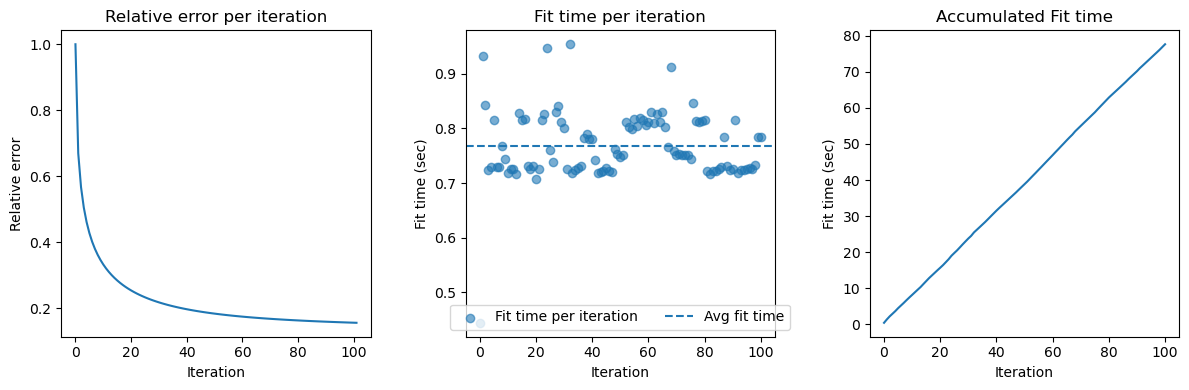

In [61]:
#
# Plot the history result
#

fig = svp_estimator.plot_result(figsize=(12, 4))
plt.show()

In [ ]:

# #Perform 5 fold CV
# cv_scores = cross_val_score(svp_estimator, sparse_matrix_train, cv=5, n_jobs=10)

# print("Cross validation errors: ", -cv_scores)
# print("Mean CV error: ", -np.mean(cv_scores))

### Improve SVP based on learning rate

In [14]:
from sklearn.model_selection import KFold
# Define a range for learning rates
learning_rates = [0.08, 0.1, 0.2, 0.5, 1]

# Perform cross-validation
cv_errors = []
for learning_rate in learning_rates:
    svp_estimator = SVPEstimator(rank=rank, learning_rate=learning_rate, max_iter=100, tol=1e-3)
    cv_scores = cross_val_score(svp_estimator, sparse_matrix_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), n_jobs=10)
    cv_errors.append(-np.mean(cv_scores))  # Convert scores to errors
    print("Cross validation errors: ", -cv_scores)
    print("Mean CV error: ", -np.mean(cv_scores))

# Find the best lambda
best_learning_rate = learning_rates[np.argmin(cv_errors)]
print(f"Best leraning rate: {learning_rate}")

# Best error
best_error_svp = np.min(cv_errors)
print(f"Best error: {best_error_svp}")


Fit time: 526.345350 seconds with 35 iterations and error 0.062799.
Fit time: 567.554138 seconds with 36 iterations and error 0.059501.
Fit time: 572.897774 seconds with 35 iterations and error 0.059296.
Fit time: 576.597844 seconds with 36 iterations and error 0.061912.
Fit time: 579.490688 seconds with 37 iterations and error 0.058775.
Cross validation errors:  [0.95945764 0.95602964 0.93400425 0.95142328 0.95331217]
Mean CV error:  0.950845395702809
Fit time: 434.294079 seconds with 29 iterations and error 0.062799.
Fit time: 446.902071 seconds with 28 iterations and error 0.061912.
Fit time: 449.548540 seconds with 28 iterations and error 0.058775.
Fit time: 456.115894 seconds with 29 iterations and error 0.059501.
Fit time: 456.949611 seconds with 28 iterations and error 0.059296.
Cross validation errors:  [0.9594225  0.95601807 0.9339909  0.95146222 0.95333579]
Mean CV error:  0.9508458980906127
Fit time: 221.946574 seconds with 14 iterations and error 0.058775.
Fit time: 222.054

### Conclusion SVP
* The SVP algorithm converges quite fast since the rank is fixed. (Hard rank constraint)
* There seems to be over-fitting happening looking at the cross validation error scores. This means that it is capturing the noise in the training folds. Probably the rank of the matrix is chosen to be too high.
* This SVP method does not have regularization. Maybe with regularization the results could be better, as we can penelize large values. (As we will see in the next algorithm)
* Increasing the data could also yield better results.
* Learning rate of 1 has the best error.

## Singular Value Threshold

SVT introduces a soft thresholding of the singular values which brings about a nuclear norm regularization.
$$
\min_{X} \|X - Y\|_F^2 + S_{\lambda} \|X\|_*
$$

### Selection of hyper parameter $\lambda$
It is very important to select the correct values for the hyper parameter $\tau$.
* $\tau$ determines the threshold for the singular values
* Larger $\tau$ values shrink more singular values towards zero, resulting in lower-rank matrices (under-fitting)
* Smaller $\tau$ values do the opposite, resulting in better fit for the training data (over-fitting)
* Using the right $\tau$ we can control the over/under fitting of the data

In our case we have selected $\tau = 0.02$ in order to have around $90\%$ of energy.

In [64]:
#SVP Estimator class to use with cross validation in scikit learn

class SVTEstimator(MatrixComletion):
    def __init__(self, max_iter=100, tol=1e-3, learning_rate=1, tau=0):
        super().__init__(max_iter=max_iter, tol=tol, learning_rate=learning_rate) 
        self.tau = tau
        

    def fit(self, Y, mask):
        
        #Init X
        self.X = lil_matrix(Y.shape, dtype = np.float64) #Sparse matrix with 64 bit float values for better stability
        X_S = mask.multiply(self.X)

        # Init parameters
        self.iter = 0
        check_stop = False
        
        while not check_stop:

            start_time = time.time()

            #Update the iteration count
            self.iter += 1

            #Update the X matrix
            X_half = self.X + self.learning_rate * (Y - X_S)
            U, S, Vt = svds(X_half, k = min(X_half.shape) - 1) # Take full possible rank
            S = np.maximum(S - self.tau, 0) #Soft thresholding according to the paper
            U_sparse = csr_matrix(U)
            Vt_sparse = csr_matrix(Vt)
            S_sparse = csr_matrix(np.diag(S))
            self.X = U_sparse @ S_sparse @ Vt_sparse 
            X_S = mask.multiply(self.X)

            #Calculate the error
            err = self._error_calc(X_S, Y)

            # Store result
            self.error.append(err)
            self.fit_time.append(time.time() - start_time)

            # Check stopping condition
            check_stop = self.stop_condition()

        total_fit_time = sum(self.fit_time)
        print(f"Fit time: {total_fit_time:.4f} seconds with {self.iter} iterations and error {self.error[-1]:.6f}.")
        return self

In [65]:
from sklearn.model_selection import KFold


# Fit once for timing purposes
svt_estimator = SVTEstimator(learning_rate=1, max_iter=100, tol=1e-3, tau=tau)
svt_estimator.fit(sparse_matrix_train, mask)

print(f"Average fit time/iteration: {np.mean(svt_estimator.fit_time)}")


Fit time: 1195.1336 seconds with 101 iterations and error 0.512979.
Average fit time/iteration: 11.833006412676065


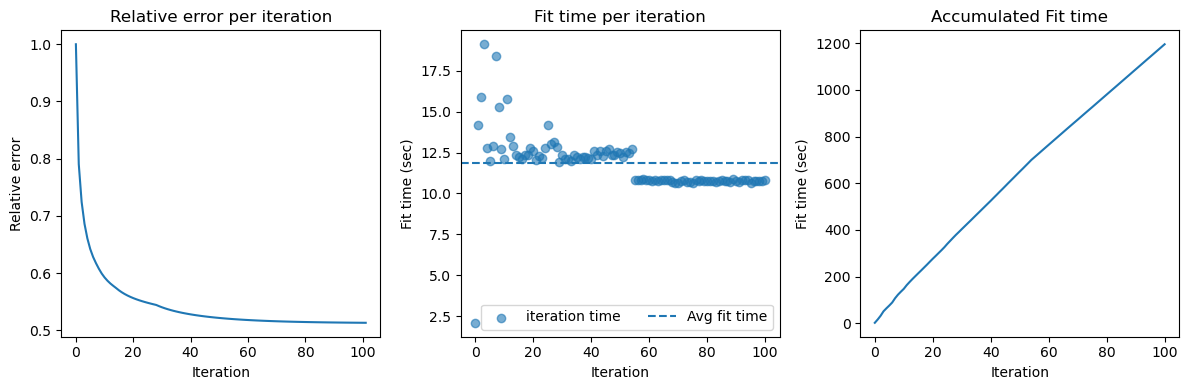

In [75]:
#
# Plot result for SVT
#
fig = svt_estimator.plot_result(figsize=(12, 4))
# fig.suptitle("SVP estimator result:")
plt.show()

### Improve SVT via learning rate

In [22]:
from sklearn.model_selection import KFold
# Define a range for learning rates
learning_rates = [0.7, 0.8, 0.9, 1]

# Perform cross-validation
cv_errors = []
for learning_rate in learning_rates:
    svp_estimator = SVTEstimator(tau=tau, learning_rate=learning_rate, max_iter=100, tol=1e-3)
    cv_scores = cross_val_score(svp_estimator, sparse_matrix_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), n_jobs=10)
    cv_errors.append(-np.mean(cv_scores))  # Convert scores to errors
    print("Cross validation errors: ", -cv_scores)
    print("Mean CV error: ", -np.mean(cv_scores))

# Find the best lambda
best_learning_rate = learning_rates[np.argmin(cv_errors)]
print(f"Best leraning rate: {learning_rate}")

# Best error
best_error_svt = np.min(cv_errors)
print(f"Best error: {best_error_svt}")

Fit time: 563.936560 seconds with 31 iterations and error 0.109637.
Fit time: 579.147510 seconds with 29 iterations and error 0.099491.
Fit time: 596.240002 seconds with 29 iterations and error 0.099346.
Fit time: 606.115481 seconds with 31 iterations and error 0.103978.
Fit time: 616.166507 seconds with 32 iterations and error 0.099348.
Cross validation errors:  [0.93941369 0.93967368 0.90919421 0.93241664 0.93610611]
Mean CV error:  0.9313608659037327
Fit time: 424.424214 seconds with 23 iterations and error 0.095932.
Fit time: 442.844289 seconds with 22 iterations and error 0.087054.
Fit time: 446.545746 seconds with 22 iterations and error 0.086928.
Fit time: 455.662537 seconds with 23 iterations and error 0.090981.
Fit time: 474.814241 seconds with 25 iterations and error 0.086930.
Cross validation errors:  [0.93989508 0.93975547 0.90949782 0.93260845 0.93624331]
Mean CV error:  0.9316000249196227
Fit time: 304.901247 seconds with 16 iterations and error 0.085273.
Fit time: 337.23

### Conclusion SVT
* SVT provides soft thresholding to the singular values
* This in essence is the nuclear norm regularization
* It is less robust to noise
* Convergence speed is slower
* Performance can get worst in presense of outlier
* $\tau$ parameter tuning is very important

## ADMiRA (Atomic decomposition for Minimization Risk Approximation)
ADMIRA is based on the idea of decomposing a signal or function into a combination of simpler, "atomic" components. These atoms are selected from a predefined dictionary (a set of basis functions or features) to best approximate the target signal. The goal is to achieve a sparse representation (using as few atoms as possible) while minimizing the approximation error or risk.

ADMIRA is an extension of the compressed sensing matching pursuit algorithm, where it iteratively selects "atoms" (rank 1 matrices) to approximate the target matrix, making it particularly useful for matrix completion and robust PCA problems. The approach is a "greedy".

The algorithm flow is as follows:  
Input the target rank.
* 1. SVD the residual and select the top 2 x Rank atoms (rank 1 matrices)
* 2. Add the selected atoms to the current approximation
* 3. Truncate to retain the top rank atoms
* 4. Update the residual (Y - X)
* 5. Calculate the error

In [76]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix, issparse
from scipy.sparse.linalg import svds
import time
from sklearn.linear_model import LinearRegression

class ADMIRAEstimator(MatrixComletion):
    def __init__(self, rank=10, max_iter=100, tol=1e-3):
        super().__init__(rank=rank, max_iter=max_iter, tol=tol) 


    def fit(self, Y, mask):

        #Init X and residual
        self.X = lil_matrix(Y.shape, dtype = np.float64)
        X_S = mask.multiply(self.X).tocsr()

        # Init parameters
        self.iter = 0
        check_stop = False

        # Init omega set of atoms
        omega = []
        
        while not check_stop:
            start_time = time.time()

            #Update the iteration count
            self.iter += 1

            # Step 1: calculate residual
            residual = Y - X_S  

            # Step 2: Select top 2 * rank atoms from the residual
            U, _, Vt = svds(residual, k = 2 * self.rank)

            # Step 3: calculate set of atoms to add to omega
            omega_add = [np.outer(U[:, i], Vt[i, :]) for i in range(2 * rank)]
            omega_half = omega + omega_add

            # Step 4: perform linear regression on omega_half with target value Y^S
            #
            # we flatten omega and Y to increase performance
            #

            omega_flat = np.hstack([o.reshape(-1, 1) for o in omega_half])  # shape (n*m, 2*rank)
            Y_flat = Y.toarray().ravel()  # shape (n*m, )

            model = LinearRegression(fit_intercept=False) 
            model.fit(omega_flat, Y_flat)
            coef = model.coef_

            # Step 5: Compute the weighted sum from atoms
            X_half = csr_matrix(omega_half[0].shape)
            for c, omega in zip(coef, omega_half):
                X_half += c * omega  

            # Step 6: Perform SVD with rank r on X_half
            U1, S1, Vt1 = svds(X_half, k = self.rank)

            # Step 7: Update omega collection of atom
            omega = [np.outer(U1[:, i], Vt1[i, :]) for i in range(self.rank)]

            # Step 8: Update X full matrix
            self.X = U1 @ np.diag(S1) @ Vt1
            X_S = mask.multiply(self.X).tocsr()

            #Calculate the error
            err = self._error_calc(X_S, Y)

            # Store result
            self.error.append(err)
            self.fit_time.append(time.time() - start_time)

            # Check stopping condition
            check_stop = self.stop_condition()
            

        total_fit_time = sum(self.fit_time)
        print(f"Fit time: {total_fit_time:.6f} seconds with {self.iter} iterations and error {self.error[-1]:.6f}.")
        return self


In [78]:
# Fit the ADMIRA model
admira = ADMIRAEstimator(rank=rank, max_iter=100, tol=1e-3, )
admira.fit(sparse_matrix_train, mask)

print(f"Average fit time/iteration: {np.mean(admira.fit_time)}")


# Save model

with open("trained_model/admira.pkl", "wb") as f:
    dill.dump(admira, f)

Fit time: 35.375254 seconds with 3 iterations and error 0.650123.
Average fit time/iteration: 11.791751384735107


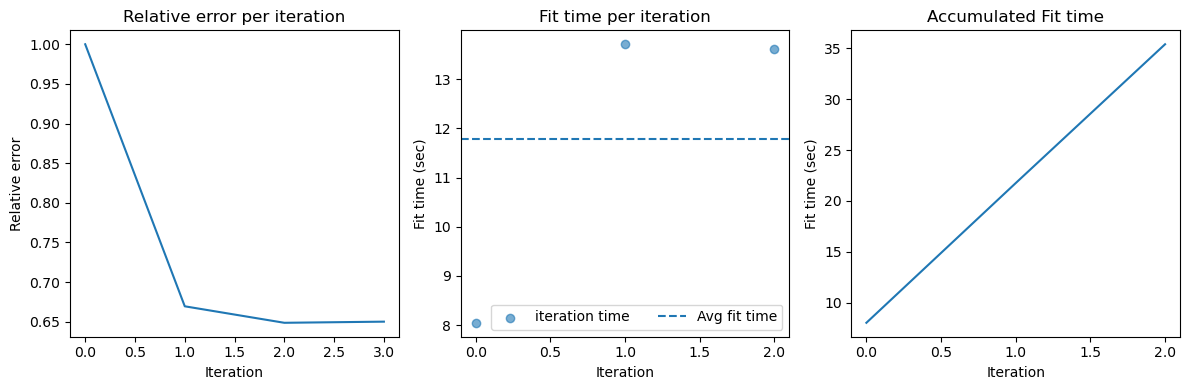

In [79]:
fig = admira.plot_result()
plt.show()

## Comparison

In this section, we compare the result of 3 algorithms both in term of relative error and computating time.

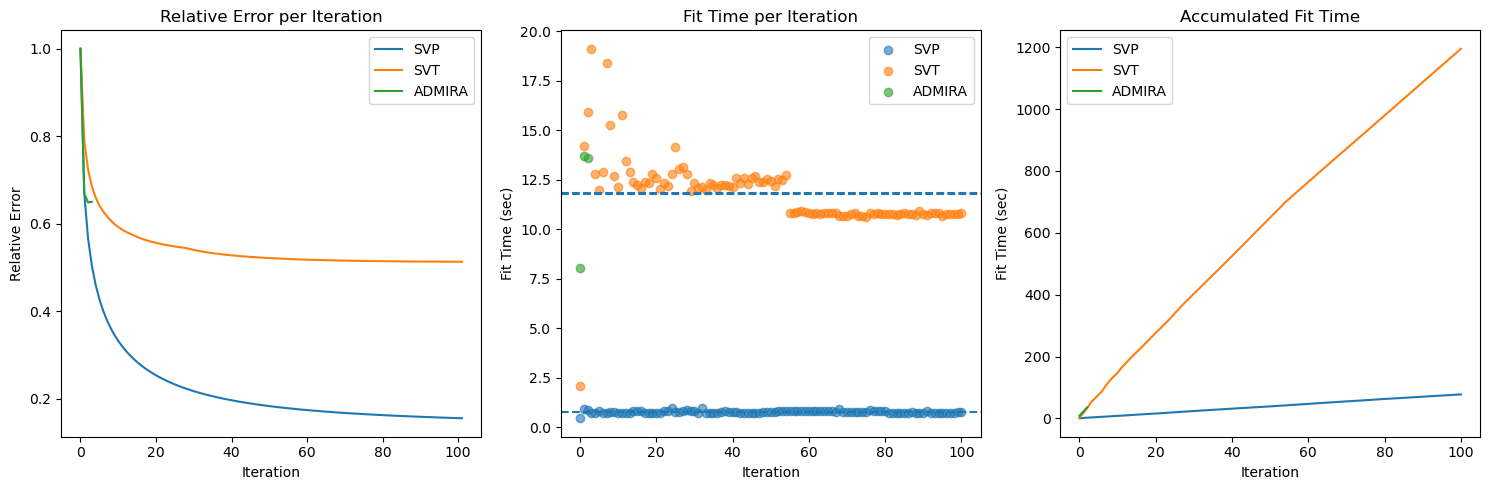

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Models dictionary
models = {
    "SVP": svp_estimator, 
    "SVT": svt_estimator, 
    "ADMIRA": admira
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

# Compare Relative Error per Iteration
for model_name, model in models.items():
    axes[0].plot(model.error, label=model_name)

axes[0].set_title("Relative Error per Iteration")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Relative Error")
axes[0].legend(loc="upper right")


# Compare Fitting Time per Iteration
for model_name, model in models.items():
    xrange = range(len(model.fit_time))
    axes[1].scatter(xrange, model.fit_time, label=model_name, alpha=0.6)
    axes[1].axhline(np.mean(model.fit_time), linestyle='--')

axes[1].set_title("Fit Time per Iteration")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Fit Time (sec)")
axes[1].legend()


# Compare Accumulated Fit Time
for model_name, model in models.items():
    sum_time = np.cumsum(model.fit_time)
    axes[2].plot(sum_time, label=model_name)

axes[2].set_title("Accumulated Fit Time")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Fit Time (sec)")
axes[2].legend(loc="upper left")

# Adjust layout
plt.tight_layout()
plt.show()


We observe that the relative error of SVP is the smallest, followed by SVT, while ADMiRA has the largest relative error. It is important to note the differences in early stopping criteria. SVP and SVT stop because they reach the maximum number of iterations (100 in our case). Looking at the graph, we see that the error curve for SVT is flatter than SVP at 100 iterations. This suggests that the SVT model is close to the stopping criterion where the model stops improving. On the other hand, if we increase the `max_iter` parameter, SVP might achieve better performance.

In contrast, ADMiRA stops very early (after just 4 iterations) because the model stops improving, and its relative error remains quite high compared to SVP and SVT.

In terms of computation time, SVP is the fastest, followed by ADMiRA, while SVT takes the longest to execute. This result is expected since, in SVT, each iteration requires computing a full-rank singular value decomposition, whereas SVP and ADMiRA only compute an SVD with a reduced rank.

### Performance and Convergence
SVP is simpler to analyze and implement than other methods and has a strong geometric convergence rate, making it faster. ADMiRA has a performance guarantee for the general case where the solution is approximately low-rank and the measurements are noisy. SVT is sensitive to noise and outliers and the convergence is slow.

### Computational Complexity and Scalability
SVP has low computational demands compared to other methods. For this dataset SVT takes longer than SVP. SVT usually becomes prohibitively expensive for moderately large datasets. ADMiRA also took a longer to execute compared to SVP.

### Choice of algorithm
SVP seems like the best choice here since the rank of the matrix is fixed in the beginning. SVP is based on iterative hard-thresholding. The algorithm involves projecting candidate solutions onto the set of low-rank matrices and has a geometric convergence rate even with noisy measurements. SVT on the other hand is sensitive to outliers and is too slow to converge. 